In [1]:
# !pip install easyocr

# Scene Text Detection

In [2]:
import easyocr
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [3]:
reader = easyocr.Reader(['en'], gpu=False)

Using CPU. Note: This module is much faster with a GPU.


In [4]:
image_path = './Demo-image/walmart.jpg'

In [5]:
result = reader.readtext(image_path)
rounded_result = [
    ([tuple(round(coord) for coord in vertices) for vertices in detection], text, confidence)
    for detection, text, confidence in result
]
# rounded_result[0]
rounded_result

[([(273, 124), (996, 124), (996, 301), (273, 301)],
  'Walmart',
  0.8845799027828035),
 ([(938, 563), (981, 563), (981, 577), (938, 577)],
  'Tten',
  0.0029794909060001373),
 ([(704, 765), (747, 765), (747, 783), (704, 783)],
  'Hiring',
  0.4361810705149336)]

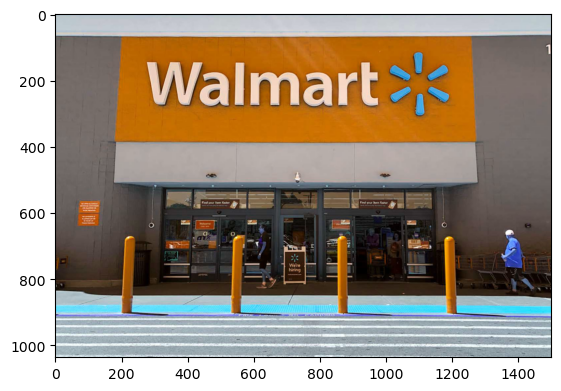

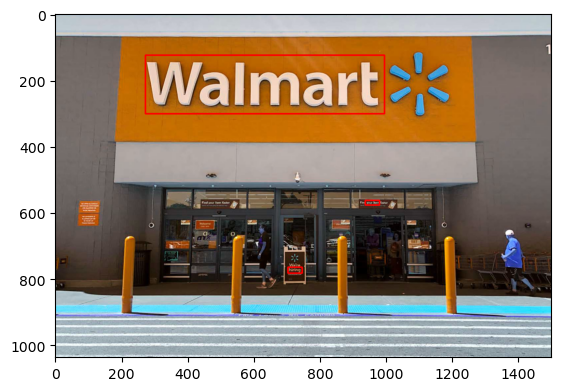

In [6]:
spacer = 100
img = cv2.imread(image_path)
image = cv2.imread(image_path)
for detection in rounded_result:
    top_left = tuple(detection[0][0])
    bottom_right = tuple(detection[0][2])
    text = detection[1]
    # font = cv2.FONT_HERSHEY_SIMPLEX
    Bounded_image = cv2.rectangle(image,top_left,bottom_right,(255,0,0),3)
    # img = cv2.putText(img,text,(20,spacer), font, 0.5,(255,0,0),1,cv2.LINE_AA)
    spacer+=15
# creating a object 
plt.imshow(img)
plt.show()
plt.imshow(Bounded_image)
plt.show()

### Cropping each word

In [7]:
import os
output_dir = "Demo_output"
os.makedirs(output_dir, exist_ok=True)

import os
import shutil
dir = 'Demo_output'
if os.path.exists(dir):
    shutil.rmtree(dir)
os.makedirs(dir)


for i, (bbox, text, confidence) in enumerate(rounded_result):
# for i, (bbox, text, confidence) in enumerate(result):
    # Convert the list of bounding box coordinates to numpy array
    bbox = np.array(bbox)

    # Compute the bounding box coordinates
    x_min = np.min(bbox[:, 0])
    y_min = np.min(bbox[:, 1])
    x_max = np.max(bbox[:, 0])
    y_max = np.max(bbox[:, 1])

    # Crop the bounding box region from the original image
    cropped_image = img[y_min:y_max, x_min:x_max]

    # Save the cropped image to the output directory
    output_path = os.path.join(output_dir, f"cropped_{i}.jpg")
    cv2.imwrite(output_path, cropped_image)

# Scene Text Recognition

In [8]:
import os
import cv2
# import numpy as np
import string
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional

# from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.compat.v1.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax

from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
from collections import Counter

from PIL import Image

In [9]:
char_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
max_label_len = 23
def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []

    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)

    return dig_lst

In [10]:
class My_Generator(Sequence):

    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):

        batch_paths = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_texts = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        training_txt = []
        train_label_length = []
        train_input_length = []

        for im_path, text in zip(batch_paths, batch_texts):

            try:
                text = str(text).strip()
                img = cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2GRAY)

                ### actually returns h, w
                h, w = img.shape

                ### if height less than 32
                if h < 32:
                    add_zeros = np.ones((32-h, w)) * 255
                    img = np.concatenate((img, add_zeros))
                    h = 32

                ## if width less than 128
                if w < 128:
                    add_zeros = np.ones((h, 128-w)) * 255
                    img = np.concatenate((img, add_zeros), axis=1)
                    w = 128

                ### if width is greater than 128 or height greater than 32
                if w > 128 or h > 32:
                    img = cv2.resize(img, (128, 32))

                img = np.expand_dims(img , axis = 2)

                # Normalize each image
                img = img / 255.

                images.append(img)
                training_txt.append(encode_to_labels(text))
                train_label_length.append(len(text))
                train_input_length.append(31)
            except:

                pass

        return [np.array(images),
               pad_sequences(training_txt, maxlen=max_label_len, padding='post', value=len(char_list)),
               np.array(train_input_length),
               np.array(train_label_length)], np.zeros(len(images))

In [11]:
# input with shape of height=32 and width=128
inputs = Input(shape=(32, 128, 1))

conv_1 = Conv2D(16, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(32, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(64, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)

conv_5 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(64, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(64, (2,2), activation = 'relu')(pool_6)

squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)
# blstm_1 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(squeezed)
# blstm_2 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(blstm_1)

outputs = Dense(len(char_list) + 1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [12]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 32, 128, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 32, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 32, 64)         18496 

In [13]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func,
                  output_shape=(1,),
                  name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [14]:
def pre_process_image(path):

    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    ### actually returns h, w
    h, w = img.shape

    ### if height less than 32
    if h < 32:
        add_zeros = np.ones((32-h, w)) * 255
        img = np.concatenate((img, add_zeros))
        h = 32

    ## if width less than 128
    if w < 128:
        add_zeros = np.ones((h, 128-w)) * 255
        img = np.concatenate((img, add_zeros), axis=1)
        w = 128

    ### if width is greater than 128 or height greater than 32
    if w > 128 or h > 32:
        img = cv2.resize(img, (128, 32))


    img = np.expand_dims(img , axis = 2)

    # Normalize each image
    img = img / 255.

    return img

In [15]:
act_model.load_weights('C_LSTM_best.hdf5')

In [16]:
def predict_output(img):
    # predict outputs on validation images
    prediction = act_model.predict(np.array([img]))
    ## shape (batch_size, num_timesteps, vocab_size)

    # use CTC decoder
    out = K.get_value(K.ctc_decode(prediction,
                                   input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                                   greedy=True)[0][0])

    ## get the final text
    result = ""
    for x in out:

#         print("predicted text = ", end = '')
        predicted_word = ""
        for p in x:

            if int(p) != -1:
                ch = char_list[int(p)]
#                 print(ch, end = '')
                predicted_word += ch
#         print('\n')
        result += predicted_word
    return result

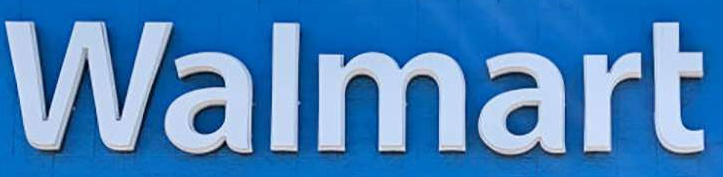



1/1 [==============================] - 0s 370ms/step
Prediction: Walmart




1/1 [==============================] - 0s 13ms/step
Prediction: Coohes




1/1 [==============================] - 0s 13ms/step
Prediction: hitined


In [17]:
from IPython.display import display
from random import randrange
# import editdistance


folder_path = "./demo_output"

# Iterate through each file in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    im = Image.open(file_path)
    display(im)
    print("\n");
    
    test_img = pre_process_image(file_path)
    predicted_text = predict_output(test_img)
    print(f"Prediction: {predicted_text}")